In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import torch
import yaml
from celldreamer.paths import ROOT

from celldreamer.estimator.celldreamer_estimator import CellDreamerEstimator
from celldreamer.paths import DATA_DIR
from celldreamer.data.utils import Args

from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.model_summary import ModelSummary

from scvi.distributions import NegativeBinomial
import torch.nn.functional as F

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
def tensor2adata(X, annot=None):
    if annot is None:
        adata = sc.AnnData(X=X.numpy())
    else:
        adata = sc.AnnData(X=X.numpy(),
                       obs=annot)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    return adata

Read config

In [3]:
config = yaml.safe_load(open(ROOT / "configs/scrna_seq/config.yaml", 
                            "rb"))
args = Args(config["args"]) 

Initialize data

In [4]:
estimator = CellDreamerEstimator(args)

Create the training folders...
Initialize data module...


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id si51ag47.


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initialize feature embeddings...
Initialize model...


In [5]:
estimator.train()

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
  rank_zero_warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /lustre/groups/ml01/workspace/alessandro.palma/celldreamer/try_experiment_eb/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                  | Params
----------------------------------------------------------
0 | denoising_model | MLPTimeStep           | 4.5 M 
1 | z0_from_x      

Sanity Checking: 0it [00:00, ?it/s]

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [6]:
# estimator.generative_model.load_state_dict(torch.load("/nfs/homedirs/pala/celldreamer/project_dir/try_experiment_eb/checkpoints/epoch_132.ckpt")["state_dict"])

Collect the batches 

In [7]:
real_data = []
annot = []
 
for batch in estimator.datamodule.train_dataloader:
    real_data.append(batch["X"])
    annot.append(batch["y"]["y_experimental_time"])

real_data = torch.cat(real_data, dim=0) 
annot = pd.DataFrame(torch.cat(annot))
annot.columns = ["experimental_time"]

In [8]:
adata_real = tensor2adata(real_data, annot)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently 

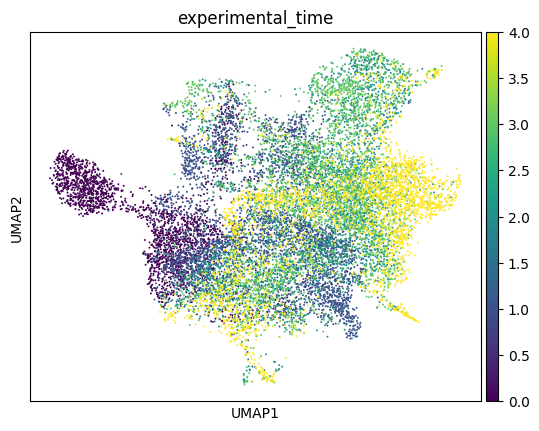

In [9]:
sc.pl.umap(adata_real, color="experimental_time")

Sampling

In [59]:
fake_data = []
zs = []

for i in range(20):
    sample, z = estimator.generative_model.sample(20, 
                                       n_sample_steps=20, 
                                       clip_samples=True, 
                                       ndim=2, library_size=1e3)
    fake_data.append(sample.to("cpu"))
    zs.append(z.to("cpu"))

sampling: 100%|██████████| 20/20 [00:00<00:00, 325.83it/s]


In [60]:
fake_data = torch.cat(fake_data, dim=0)

In [61]:
fake_data.sum(1)

tensor([ 845.,  971., 1484.,  812., 1606.,  835.,  814.,  847.,  905.,  746.,
         917.,  922.,  942.,  893.,  860.,  935.,  969.,  926., 1027.,  792.,
         828.,  978., 1819., 1404.,  741., 1286.,  979.,  870.,  963.,  892.,
        1285., 1296., 1137.,  894.,  824.,  990.,  879.,  805.,  914.,  875.,
         865.,  797.,  883.,  904., 1166.,  874., 1083.,  915.,  821., 2089.,
         880., 1005.,  967., 1118., 1416., 1672., 1028.,  921.,  903.,  755.,
         831.,  939.,  906., 1107.,  879., 1031.,  965.,  916.,  881., 1262.,
         971.,  990.,  754., 1076.,  669.,  841.,  866., 1037., 1018., 1000.,
        1227.,  773.,  898.,  928., 1777., 1165.,  878., 1304.,  712.,  837.,
         801., 1067.,  831.,  856.,  856., 3413.,  938.,  883., 1157., 1028.,
        1222.,  798.,  978.,  916.,  869., 1011., 1685., 1378.,  952.,  745.,
         863.,  743.,  767., 1056.,  875.,  899.,  902.,  810., 1206.,  817.,
         884.,  880.,  794.,  938.,  887.,  896.,  890.,  941., 

In [62]:
adata_fake = tensor2adata(fake_data, annot=None)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


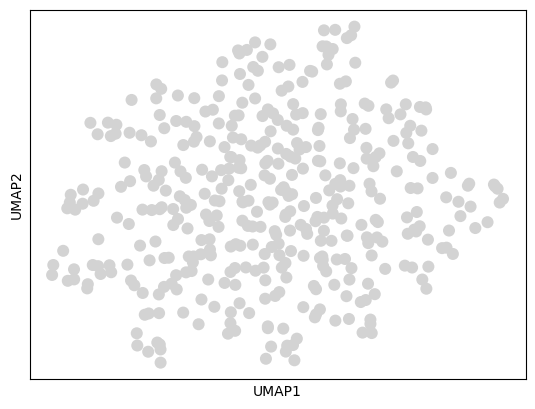

In [63]:
sc.pl.umap(adata_fake)

In [64]:
z

tensor([[ 0.1320, -1.1611, -0.2163,  ...,  2.3440, -1.3253, -2.4290],
        [ 0.3399, -0.0574,  0.1926,  ..., -0.6697,  0.2566,  1.0572],
        [-0.6209,  2.3485, -0.1991,  ...,  1.4416, -0.0194, -0.9983],
        ...,
        [-0.0929, -0.5407, -1.4306,  ..., -0.7051,  2.0389, -3.0290],
        [ 0.9639,  1.5758,  1.2329,  ..., -2.3596,  0.2686,  0.3850],
        [ 1.0952,  0.3726, -0.4192,  ...,  1.1017, -0.0121,  0.2742]])

Match matrices together

In [65]:
real_and_fake_data = torch.cat([real_data, fake_data], dim=0)

In [66]:
real_and_fake_data

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 2.8137, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [67]:
annot = ["true" for _ in range(len(real_data))] + ["fake" for _ in range(len(fake_data))]
annot = pd.DataFrame(annot)
annot.columns = ["Dataset"]
adata_real_and_fake = tensor2adata(real_and_fake_data, annot)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


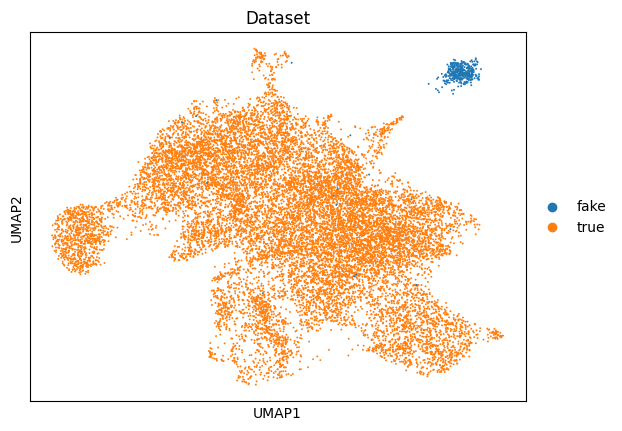

In [68]:
sc.pl.umap(adata_real_and_fake, color="Dataset")

In [69]:
for i in fake_data.sum(1):
    print(i)

tensor(845.)
tensor(971.)
tensor(1484.)
tensor(812.)
tensor(1606.)
tensor(835.)
tensor(814.)
tensor(847.)
tensor(905.)
tensor(746.)
tensor(917.)
tensor(922.)
tensor(942.)
tensor(893.)
tensor(860.)
tensor(935.)
tensor(969.)
tensor(926.)
tensor(1027.)
tensor(792.)
tensor(828.)
tensor(978.)
tensor(1819.)
tensor(1404.)
tensor(741.)
tensor(1286.)
tensor(979.)
tensor(870.)
tensor(963.)
tensor(892.)
tensor(1285.)
tensor(1296.)
tensor(1137.)
tensor(894.)
tensor(824.)
tensor(990.)
tensor(879.)
tensor(805.)
tensor(914.)
tensor(875.)
tensor(865.)
tensor(797.)
tensor(883.)
tensor(904.)
tensor(1166.)
tensor(874.)
tensor(1083.)
tensor(915.)
tensor(821.)
tensor(2089.)
tensor(880.)
tensor(1005.)
tensor(967.)
tensor(1118.)
tensor(1416.)
tensor(1672.)
tensor(1028.)
tensor(921.)
tensor(903.)
tensor(755.)
tensor(831.)
tensor(939.)
tensor(906.)
tensor(1107.)
tensor(879.)
tensor(1031.)
tensor(965.)
tensor(916.)
tensor(881.)
tensor(1262.)
tensor(971.)
tensor(990.)
tensor(754.)
tensor(1076.)
tensor(669.)
tens

Check encoder training

In [22]:
fake_data_from_z0 = []
annot_from_z0 = []

for batch in estimator.datamodule.train_dataloader:
    library_size = batch["X"].sum(1)
    z0 = estimator.generative_model.z0_from_x(estimator.generative_model._scale_batch(batch["X"]))
    z0_softmax = F.softmax(z0, dim=1)
    distr = NegativeBinomial(mu=library_size.unsqueeze(1)*z0_softmax, 
                             theta=torch.exp(estimator.generative_model.theta))
    fake_data_from_z0.append(distr.sample())
    annot_from_z0.append(batch["y"]["y_experimental_time"])

fake_data_from_z0 = torch.cat(fake_data_from_z0, dim=0) 
annot_from_z0 = pd.DataFrame(torch.cat(annot_from_z0))
annot_from_z0.columns = ["experimental_time"]

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
fake_data_from_z0

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [24]:
estimator.generative_model.z0_from_x

MLP(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1579, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=1579, bias=True)
      (1): BatchNorm1d(1579, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
  )
)

In [35]:
estimator.generative_model.z0_from_x(estimator.generative_model._scale_batch(batch["X"]))

tensor([[-0.0824, -0.4882, -0.1901,  ...,  0.0441, -0.2310, -0.2972],
        [-0.1625, -0.3195, -0.1817,  ..., -0.1807, -0.2048, -0.3615],
        [-0.1745, -0.2064, -0.1294,  ..., -0.0868, -0.1321, -0.1408],
        ...,
        [-0.2095, -0.2802, -0.1839,  ..., -0.1885, -0.1923, -0.2174],
        [-0.1527, -0.1154, -0.1878,  ..., -0.2951, -0.1487, -0.0869],
        [-0.1362, -0.2513, -0.0875,  ..., -0.3990, -0.2160, -0.0457]],
       grad_fn=<EluBackward0>)

In [26]:
F.softmax(estimator.generative_model.z0_from_x(torch.log(1+batch["X"])), dim=1)

tensor([[1.0447e-04, 6.9629e-05, 9.3812e-05,  ..., 1.1857e-04, 9.0047e-05,
         8.4283e-05],
        [8.9107e-05, 7.6161e-05, 8.7414e-05,  ..., 8.7506e-05, 8.5420e-05,
         7.3028e-05],
        [1.3013e-04, 1.2604e-04, 1.3613e-04,  ..., 1.4205e-04, 1.3576e-04,
         1.3458e-04],
        ...,
        [1.2660e-04, 1.1797e-04, 1.2989e-04,  ..., 1.2930e-04, 1.2881e-04,
         1.2561e-04],
        [8.7801e-05, 9.1135e-05, 8.4773e-05,  ..., 7.6146e-05, 8.8154e-05,
         9.3768e-05],
        [9.8348e-05, 8.7654e-05, 1.0326e-04,  ..., 7.5622e-05, 9.0809e-05,
         1.0767e-04]], grad_fn=<SoftmaxBackward0>)

In [27]:
real_and_fake_data = torch.cat([real_data, fake_data_from_z0], dim=0)

In [28]:
annot = ["true" for _ in range(len(real_data))] + ["fake" for _ in range(len(fake_data_from_z0))]
annot = pd.DataFrame(annot)
annot.columns = ["Dataset"]
adata_real_and_fake = tensor2adata(real_and_fake_data, annot)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


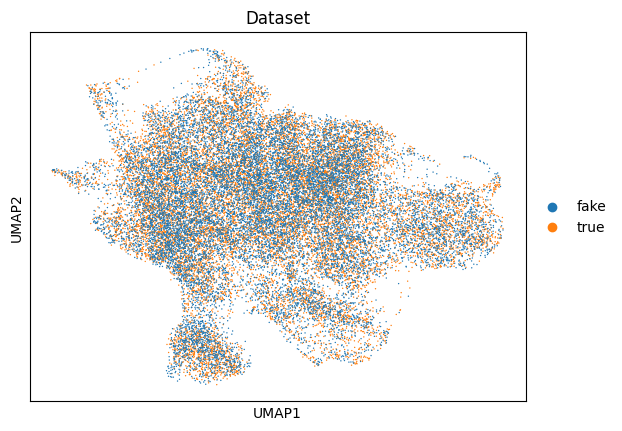

In [29]:
sc.pl.umap(adata_real_and_fake, color="Dataset")